# FMR Analysis

This time I have better data.

In [14]:
import numpy as np
import pandas as pd
from skrf import Network
import matplotlib.pyplot as plt
import glob
import os.path
from scipy.optimize import curve_fit

In [3]:
def read_FMR_s21(folder_path):
    # check if given folder is valid
    if (False == os.path.isdir(folder_path)):
        raise Exception("Sorry, the folder from where you want me to read the FMR data does not exit")
    
    if "/" != folder_path[-1]:
        folder_path += "/"

    # define the data structure as a dictionary with: key: string same as filename + value: dataframe containing FMR data
    FMR_data = {}
    file_list = glob.glob("*.s2p", root_dir=folder_path)
    
    for file in file_list:
        # the key is the file name (i have to remove path and extension)
        file_name = file[file.rfind("_") + 1 : file.find("mT.s2p")]
        FMR_data[file_name] = Network(folder_path + file).to_dataframe().drop(columns=["s_db 11", "s_db 22", "s_db 12"])

        # rename columns
        FMR_data[file_name] = FMR_data[file_name].reset_index().rename({"index": "freq", "s_db 21": "Sparam"}, axis='columns')

    return FMR_data

In [37]:
# TODO find the resolution of the data, so that it is not hard coded into the function
def calibrate(FMR_GHz_range, cal_field="", smoothing_freq_window=0.75*1e6, plot=False, units="Hz"):
    multiplier = 1
    if str.lower(units) == "mhz":
        multiplier = 1e6
    elif str.lower(units) == "ghz":
        multiplier = 1e9
    
    # make a copy so i dont destroy data
    FMR = {}
    max_field = 0
    for field in FMR_GHz_range:
        FMR[field] = FMR_GHz_range[field].copy()
        # find the maximum field measured for this range (for which the resonance should be outside the range)
        if max_field < int(field):
            max_field = int(field)

    # subtract highest field data from each dataset
    if plot:
        fig, ax = plt.subplots()
    
    if "" == cal_field:
        cal_field = str(max_field)
    
    
    for field in FMR_GHz_range:
        FMR[field].Sparam = FMR_GHz_range[field].Sparam - FMR_GHz_range[cal_field].Sparam
        FMR[field].freq = FMR[field].freq / multiplier
        if plot:
            ax.plot(FMR[field].freq, FMR[field].Sparam, label=field + "mT")
            
    if plot:
        ax.legend(fontsize=9, loc="lower left")
        ax.set(xlabel=units, ylabel="S21 (arbitrary units)")
        #fig.savefig("7-10GHz", dpi=300)

    # get rid of 0 field and the maximum field
    FMR.pop("0")
    FMR.pop(str(max_field))

    # smooth out the data TODO fix, not working
    avg_window = int(np.around(smoothing_freq_window / (0.75*1e6)))

    if 1 < avg_window:
        for field in FMR:
            FMR[field].Sparam = FMR[field].Sparam.rolling(avg_window).sum() / avg_window

    return FMR




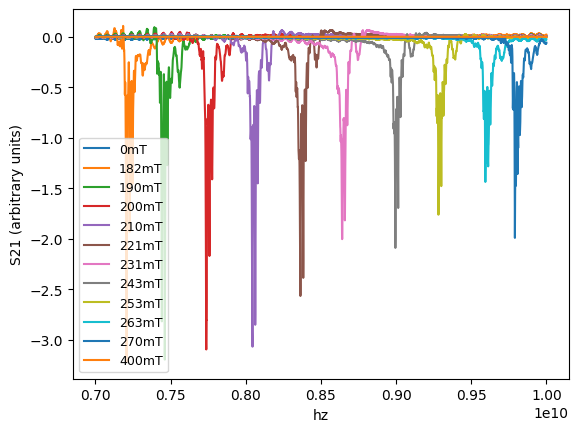

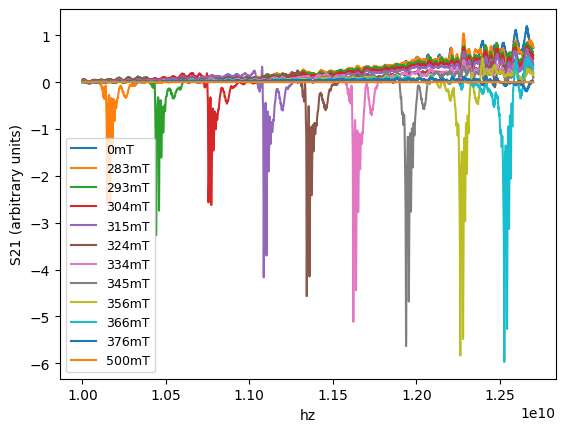

In [49]:
units = "hz"

FMR_1_4GHz = read_FMR_s21("./6_march/1-4GHz/")
# pop is acting up
FMR_1_4GHz = calibrate(FMR_1_4GHz, units=units)#.pop("97")
del FMR_1_4GHz["97"]

FMR_4_7GHz = read_FMR_s21("./6_march/4-7GHz/")
FMR_4_7GHz = calibrate(FMR_4_7GHz, units=units)

FMR_7_10GHz = read_FMR_s21("./6_march/7-10GHz/")
FMR_7_10GHz = calibrate(FMR_7_10GHz, plot=True, units=units)

FMR_10_13GHz = read_FMR_s21("./6_march/10-13GHz/")

# this one needs to be cut off for freq>12.7GHz
for field in FMR_10_13GHz:
    FMR_10_13GHz[field] = FMR_10_13GHz[field][FMR_10_13GHz[field].freq < 12.7 * 1e9]
FMR_10_13GHz = calibrate(FMR_10_13GHz, plot=True, units=units)#.pop("376")
del FMR_10_13GHz["376"]


Fit all of these peaks to a Lorentzian.

In [50]:
# combine all the data
def merge_dicts(*dict_args):
    """
    Given any number of dictionaries, shallow copy and merge into a new dict,
    precedence goes to key-value pairs in latter dictionaries.
    """
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

FMR = merge_dicts(FMR_1_4GHz, FMR_4_7GHz, FMR_7_10GHz, FMR_10_13GHz)

res_fit_list = {}
HWHM_fit_list = {}
peak_fit_list = {}
offset_fit_list = {}

err_res_list = {}
err_HWHM_list = {}
err_peak_list = {}

def lorentzian (x, res, HWHM, peak, offset): 
    return peak / (((x-res)/HWHM)**2 + 1) + offset

for field in FMR:
    res_freq = FMR[field].freq.iloc[FMR[field].Sparam.idxmin()]
                                
    [res_freq, HWHM, peak, offset], pcov = curve_fit(f=lorentzian, xdata=FMR[field].freq, ydata=FMR[field].Sparam,
                                        p0=[res_freq+1e7, 5e7, -3, 0], maxfev=10000,
                                        bounds=([res_freq - 5e7, 1e7, -10, -0.1], 
                                                [res_freq + 5e7, 1e9, -0.1, 0.1]) )
    # record fitted parameters
    res_fit_list[field] = res_freq
    HWHM_fit_list[field] = HWHM
    peak_fit_list[field] = peak
    offset_fit_list[field] = offset

    # record the standard deviations of the fitted parameters
    [ err_res_list[field], err_HWHM_list[field], err_peak_list[field], _] = np.sqrt(np.diag(pcov))

In [51]:
plt.ioff()
for field in FMR:
    fig, ax = plt.subplots()

    res = res_fit_list[field]
    # plot the data and the fit in a window of size 1GHz around the peak
    freq_wind = 1e9
    freq_range = np.arange(res - freq_wind/2, res + freq_wind/2, 5e5)
    trimmed_data = FMR[field][(res - freq_wind/2 < FMR[field].freq) & (FMR[field].freq < res + freq_wind/2)]

    ax.scatter(trimmed_data.freq, trimmed_data.Sparam, label="data", marker=".", c="orange")
    ax.plot(freq_range, lorentzian(freq_range, res, HWHM_fit_list[field], peak_fit_list[field], offset_fit_list[field]), label="fit")
    ax.set(title="FMR of YIG at " + field + " mT")
    ax.legend()
    fig.savefig(fname="./min_width_fits/" + field + "mT", dpi=200)
    plt.close(fig)

    

plt.ion()

In [95]:
# combine all the data
def merge_dicts(*dict_args):
    """
    Given any number of dictionaries, shallow copy and merge into a new dict,
    precedence goes to key-value pairs in latter dictionaries.
    """
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

FMR = merge_dicts(FMR_1_4GHz, FMR_4_7GHz, FMR_7_10GHz, FMR_10_13GHz)

for field in FMR:
    print(field)

12
20
30
40
49
61
70
105
116
125
136
146
157
168
84
95
182
190
200
210
221
231
243
253
263
270
283
293
304
315
324
334
345
356
366


In [23]:
print(HWHM_fit_list)

{'12': 115237950.26760076, '20': 66510025.07944606, '30': 42866316.94114914, '40': 34553194.54314059, '49': 22850935.306017075, '61': 1605652.8278458691, '70': 2383630.9336196627, '105': 2358737.9962954656, '116': 4636979.487393328, '125': 2985310.001646441, '136': 1994382.9297477296, '146': 1954938.9138014202, '157': 26812023.86709745, '168': 24904641.060667314, '84': -1867503.2622427288, '95': 2940247.3682077066, '182': 29517608.071729325, '190': 24573290.188713316, '200': 24190392.806060165, '210': 23974538.969961897, '221': 23887717.409737255, '231': 23612196.312077906, '243': 22009488.391278636, '253': 23226809.778449215, '263': 26317071.051365748, '270': 26906721.45172964, '283': 307497517368.5318, '293': 1339422101.9900348, '304': 45962213.11049927, '315': 34526890.973997235, '324': 27354829.450182755, '334': 26649430.202356916, '345': 22876010.842750948, '356': 21697316.615286373, '366': 21935623.4945033}
